In [16]:
import numpy as np

import functions as fu
import animation_func as anim

### Simulation Parameters

In [17]:
# SIMULATION PARAMETERS

L = 10.0
N = 500
time_steps = 1000
T = 1000

### Initial Condition

In [18]:
# INITIAL CONDITIONS

res = N
voffset = 0.0
wfcoffset = 0.0
n = 0
q0_func = lambda t: 10 * t / T

## Code - REAL TIME

In [19]:
im_time = False

In [20]:
# Initialize the Param object
par = fu.Param(L, N, T, time_steps, im_time)

# Initialize the Operators object
opr = fu.Operators(res, voffset, wfcoffset, n, q0_func, par)

In [21]:
print(f"The final energy of the systems is: {opr.energy_history[-1]}")

The final energy of the systems is: 0.5000000000000006


In [22]:
par.num_t

1000

In [23]:
par.num_t //100

10

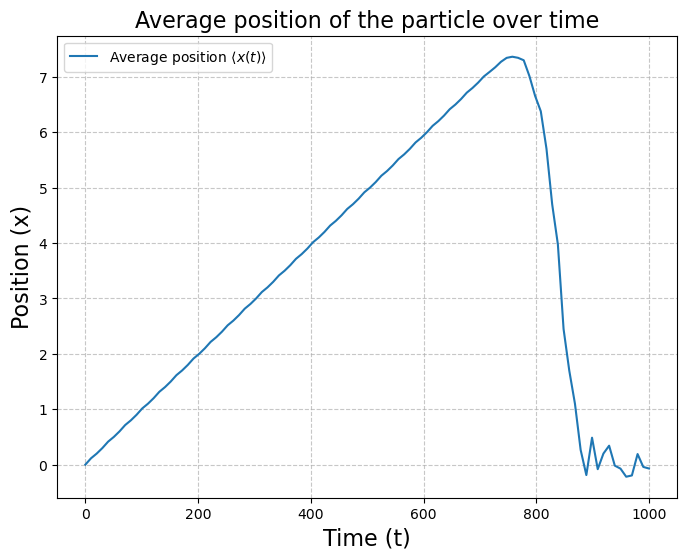

In [24]:
# Run the simulation and get the results
density, potential, avg_position = fu.split_op(par, opr)

# Time array (100 elements)
time = np.linspace(0, par.tsim, 100)

filename = f"n={n}_real_T={T}.png"

anim.plot_average_position(time, avg_position, n, filename)

In [25]:
filename = f"n={n}_real_T={T}.gif"
anim.gif_animation(n, par, density, potential, avg_position, filename)

Animation saved as 'n=0_real_T=1000.gif'


## Code - IMAGINARY TIME

In [26]:
im_time = True

In [27]:
# Initialize the Param object
par = fu.Param(L, N, T, time_steps, im_time)


# Initialize the Operators object
opr = fu.Operators(res, voffset, wfcoffset, n, q0_func, par)

In [28]:
print(f"The final energy of the systems is: {opr.energy_history[-1]}")

The final energy of the systems is: 0.5000000000000006


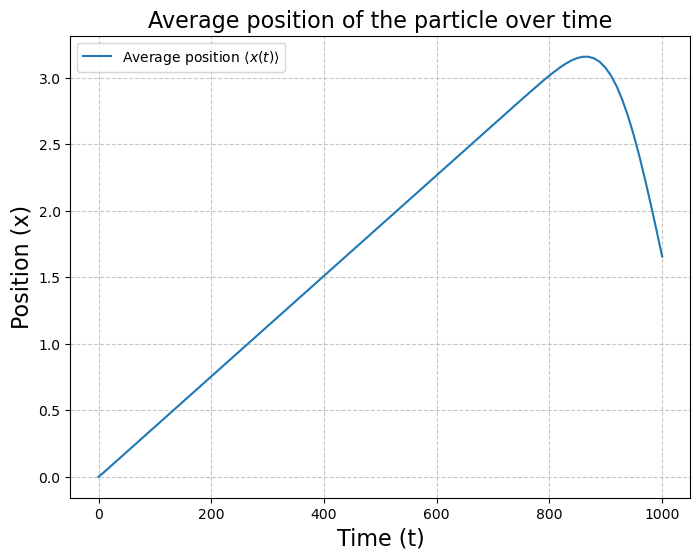

In [29]:
# Run the simulation and get the results
density, potential, avg_position = fu.split_op(par, opr)

# Time array (100 elements)
time = np.linspace(0, par.tsim, 100)

filename = f"n={n}_imaginary_T={T}.png"

anim.plot_average_position(time, avg_position, n, filename)

In [30]:
filename = f"n={n}_imaginary_T={T}.gif"

anim.gif_animation(n, par, density, potential, avg_position, filename)

Animation saved as 'n=0_imaginary_T=1000.gif'
